<a href="https://colab.research.google.com/github/loveiscomplicated/Lexile_BERT_HEAD/blob/main/LEXILE_PREDICTOR_loveiscomplicated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 전체 플로우
## 1. 데이터 수집
## 2. 데이터 전처리 1 - 수집한 두 데이터를 하나로 합치기(all_raw_data.csv로 저장)
## 3. 데이터 전처리 2 - all_raw_data 토큰화, 렉사일 지수를 적절한 기준에 따라 범주화 (final_data.pkl로 저장)
## 4. 데이터 전처리 3 - final_data.pkl을 BERT에 입력, 결과물 저장 (bert_embeddings.pkl로 저장)
## 5. 데이터 전처리 4 - train_test_split, 데이터 텐서로 변환
## 6. 모델 구축
## 7. 모델 훈련 및 최선의 모델 저장
## 8. 모델 평가


모델 구축 방법

BERT head + FC layer(Fully connected layer)

BERT의 파라미터는 그대로 고정하고, FC layer만 학습시키는 방법
시간 단축, 컴퓨팅 리소스 절약할 수 있는 동시에 BERT라는 강력한 자연어 처리 모델을 활용할 수 있다는 점에서 해당 방법론 선택




## 1. 데이터 수집

카글(kaggle)과 github(eannefawcett)에서 공개된 데이터 이용


카글 자료 출처 = https://www.kaggle.com/datasets/kononenko/commonlit-texts
commonlit_texts.csv을 저장

github(제작자명: eannefawcett) = https://github.com/eannefawcett/lexile-determination-v2/tree/master/data/raw
labeled_data.pickle을 저장

1. 구글 드라이브의 내 드라이브 - (만약 없다면 생성) Colab Notebooks 폴더 - LEXILE 폴더 생성 - data 폴더 생성
2. 이 두 데이터를 1.의 해당 경로 안에 업로드
3. 코랩을 구글 드라이브와 연결하여 데이터 불러오기

In [ ]:
import pandas as pd
import pickle


In [ ]:
# Google Drive 마운트 (데이터 파일 접근을 위해)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# 카글에서 가져온 commonlit_texts.csv 불러오기
path = '/content/drive/MyDrive/Colab Notebooks/LEXILE/data/commonlit_texts.csv'
print(f"Loading data from: {path}")
with open(path, 'r') as f:
    commonlit = pd.read_csv(f)
    print(commonlit.head())


Loading data from: /content/drive/MyDrive/Colab Notebooks/LEXILE/data/commonlit_texts.csv
                                               title  \
0                     (love song, with two goldfish)   
1                10 Things You Can Do to Avoid Fraud   
2  100 years ago: An election, a virus and a cry ...   
3                                     13 Concussions   
4                                           The 13th   

                     author  \
0                Grace Chua   
1  Federal Trade Commission   
2          Michael E. Ruane   
3             Casey Cochran   
4            Shelley Walden   

                                         description  grade  \
0  The speaker describes a love story between two...      8   
1  The Federal Trade Commission discusses what pe...     10   
2  In 2020, a news reporter takes a look back at ...     11   
3  In this article, a former college football pla...      9   
4  When the COVID-19 lockdown begins, a superstit...      6   

       

In [ ]:
# github에서 가져온 labeled_data.pkl 불러오기
path = '/content/drive/MyDrive/Colab Notebooks/LEXILE/data/labeled_data.pickle'
print(f"Loading data from: {path}")
with open(path, 'rb') as f:
    labeled_data = pickle.load(f)
    print(labeled_data.head())


Loading data from: /content/drive/MyDrive/Colab Notebooks/LEXILE/data/labeled_data.pickle
  Lexiles         Titles                                              Texts
0   1150L  Eight Cousins  The Project Gutenberg EBook of Eight Cousins, ...
1   1200L  Flower Fables  The Project Gutenberg EBook of Flower Fables, ...
2  AD550L  Jack And Jill  The Project Gutenberg EBook of Jack and Jill, ...
3   1120L      Jo'S Boys  The Project Gutenberg EBook of Jo's Boys, by L...
4   1150L     Little Men  The Project Gutenberg EBook of Little Men, by ...


##2. 데이터 전처리 1 - 수집한 두 데이터셋을 하나의 데이터셋(all_raw_data.csv)으로 만들기


단,

1. 렉사일 지수, 그리고 글을 column으로 한 데이터 프레임으로 만들어야 함
2. 렉사일 지수는 정수형 데이터여야 함
3. 결측치가 없어야 함

###2-1 commonlit에서 lexile 열과 text열만 추출
###2-2 labeled_data에서 lexile 열과 text열만 추출
+ (추가적으로) lexile열의 데이터들이 알파벳이 포함된 문자열임 -> 수정하기

###2-3 all_raw_data로 합치기 + csv 형식으로 저장

In [ ]:
import pandas as pd
import pickle
import re

In [ ]:
###2-1 commonlit에서 lexile 열과 text열만 추출
# 결측치를 제거하고 텍스트 열을 사용
data = pd.DataFrame()
data['text'] = commonlit['text']
data['lexile'] = commonlit['lexile']
data = data.dropna()

print(data.shape)

(1623, 2)


In [ ]:
###2-2 labeled_data에서 lexile 열과 text열만 추출
# lexile열의 데이터들이 알파벳이 포함된 문자열임 -> 수정하기

labeled_data['cleaned_lexile'] = labeled_data['Lexiles'].apply(lambda x: int(re.search(r'\d+', x).group()))
print(labeled_data['cleaned_lexile'].head(10))

new_data = pd.DataFrame()
new_data['lexile'] = labeled_data['cleaned_lexile']
new_data['text'] = labeled_data['Texts']
print(new_data.head(), new_data.shape)

0    1150
1    1200
2     550
3    1120
4    1150
5     790
6    1210
7    1290
8    1360
9     590
Name: cleaned_lexile, dtype: int64
   lexile                                               text
0    1150  The Project Gutenberg EBook of Eight Cousins, ...
1    1200  The Project Gutenberg EBook of Flower Fables, ...
2     550  The Project Gutenberg EBook of Jack and Jill, ...
3    1120  The Project Gutenberg EBook of Jo's Boys, by L...
4    1150  The Project Gutenberg EBook of Little Men, by ... (264, 2)


In [ ]:
###2-3 all_raw_data로 합치기 + csv 형식으로 저장
concat_data = pd.concat([data, new_data], axis=0)
print(concat_data.head(), concat_data.shape)
concat_data.to_csv('/content/drive/MyDrive/Colab Notebooks/LEXILE/data/all_raw_data.csv', index=False)



                                                text  lexile
1  International scam artists use clever schemes ...  1100.0
2  A critical election loomed. The country was de...  1140.0
3  It was a beautiful night in late August. We we...   810.0
4  As Angela stared out the school bus window, he...   700.0
5  In the 1950s and 1960s, racial conflicts were ...  1110.0 (1887, 2)


## 3. 데이터 전처리 2 - all_raw_data 토큰화, 렉사일 지수를 적절한 기준에 따라 범주화 (final_data.pkl로 저장)




###1. 토큰화 방법
- BERT는 한 번에 512토큰까지 처리 가능함
- BERT는 CLS 토큰과 SEP 토큰으로 둘러싸여 있는 부분을 한 문장으로 인식
- 그러한 방식으로 최대 두 문장까지밖에 인식 불가
- 하지만 지금 all_raw_data.csv의 한 셀 안에 수많은 문장들이 들어 있음
- 즉 각각의 셀마다 512토큰을 훌쩍 넘는 길이의 글들이 3개 이상의 문장들로 존재
- 이를 적절히 해결하기 위해 다음과 같은 방법을 거칠 것
-- 하나의 셀이 512토큰을 넘으면 쪼개기
-- 실제로는 여러 문장들로 구성되어 있어도 앞뒤로 CLS 토큰과 SEP 토큰을 넣어서 한 문장인 것처럼 만들기

-- 하나의 셀이 512토큰을 넘으면 쪼개기 -> 이 경우 뒤에 남은 꼬다리 글의 길이가 너무 짧을 수 있음

-- 그게 아니더라도 길이가 너무 짧은 글들은 제거해야 함 (정보가 너무 없기 때문)

---> 해결 방법: 토큰 길이의 분포, 사분위수를 파악하여 토큰 길이의 하한선 설정, 기준 미달인 행 제거

----마지막으로 패딩, attention mask, token type id 추가


-----------------------------------------------------------------------------


###2. 렉사일 지수를 적절한 기준에 따라 범주화
- 회귀 모델을 구성하기보다 범주 예측 모델을 만드는 것이 더 적합함
- 우리의 궁극적인 목표는 적절한 난이도의 글을 학생에게 추천하는 것
- 범주의 수가 너무 적지만 않다면 범주 예측 모델로도 충분히 가능함
- 이에 비해 정확한 하나의 숫자로 예측하는 것에 대한 메리트가 크지 않음

-----그렇다면 어떤 기준에 따라 렉사일 지수 구간을 나눌 것인가?
1. 범주의 개수가 너무 적으면 안 됨 (예를 들어 2~4개 범주로 나누는 경우)
2. 각 범주마다 비슷한 개수의 데이터가 있어야 함 (성능이 좋은 모델을 만들기 위해)

이에 따라

- 렉사일 지수의 분포를 히스토그램으로 파악
- 시행착오 끝에 6개 범주, 각 경계값은 (100/6)% 퍼센타일로 하면 앞의 두 조건을 만족시킬 수 있다는 것을 알게 되었음 + 렉사일 지수 구간의 크기도 약 200씩으로 일정한 편
- 그렇게 범주화 진행, 렉사일 지수가 가장 작은 구간부터 0~5의 정수 부여 (다중 분류 모델을 학습시키기 위한 loss function으로 cross entropy가 주로 사용되며, 이 함수를 사용하기 위해서는 이런 방식으로 레이블을 붙여야 함


###3. all_raw_data 토큰화, 0~5로 범주화된 렉사일 지수를 (final_data.pkl로 저장)


In [ ]:
from transformers import BertTokenizer
import pandas as pd
import pickle
import torch # 머신러닝, 딥러닝 모델 구축, gpu 적극적으로 활용 가능해짐 ex) .to(device)
import nltk
from nltk.tokenize import sent_tokenize

In [ ]:
# Google Drive 마운트 (데이터 파일 접근을 위해)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# all_raw_data.csv 데이터 로드
# 데이터 경로 설정 (Google Drive에 있는 파일 경로)
path = '/content/drive/MyDrive/Colab Notebooks/LEXILE/data/all_raw_data.csv'
print(f"Loading data from: {path}")
raw_data = pd.read_csv(path)


Loading data from: /content/drive/MyDrive/Colab Notebooks/LEXILE/data/all_raw_data.csv


In [ ]:
# 잘 로드되었는지 확인
print(raw_data.head())

                                                text  lexile
0  International scam artists use clever schemes ...  1100.0
1  A critical election loomed. The country was de...  1140.0
2  It was a beautiful night in late August. We we...   810.0
3  As Angela stared out the school bus window, he...   700.0
4  In the 1950s and 1960s, racial conflicts were ...  1110.0


In [ ]:
# 데이터 로드 및 토크나이저 초기화
raw_data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 결측치 제거
raw_data = raw_data.dropna(subset=['text']).reset_index(drop=True)

# 결과를 저장할 DataFrame 초기화
final_data = pd.DataFrame(columns=["input_ids", "raw_index"])

# 슬라이딩 윈도우 함수 정의
def sliding_window(text, index, max_length=512):
    tokens = tokenizer.encode(text, add_special_tokens=False, truncation=False)  # truncation=False로 명시적으로 설정
    windows = []

    # 슬라이딩 윈도우 적용
    start = 0
    while start < len(tokens):
        end = min(start + max_length - 2, len(tokens))
        window = tokens[start:end]
        window = [tokenizer.cls_token_id] + window + [tokenizer.sep_token_id]  # CLS, SEP 추가
        windows.append((window, index))
        start += max_length - 2  # 윈도우 중첩 간격 조정

    return windows

# 각 행에 대해 슬라이딩 윈도우 적용
all_windows = []
for idx, row in raw_data.iterrows():
    try:
        windows = sliding_window(row['text'], idx)
        for window, raw_idx in windows:
            all_windows.append({"input_ids": window, "raw_index": raw_idx})
    except Exception as e:
        print(f"Error processing row {idx}: {e}")

# 최종 DataFrame으로 변환
final_data = pd.DataFrame(all_windows)

# 결과 확인
print(final_data.head())
print("Final shape of final_data:", final_data.shape)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1019 > 512). Running this sequence through the model will result in indexing errors


                                           input_ids  raw_index
0  [101, 2248, 8040, 3286, 3324, 2224, 12266, 116...          0
1  [101, 2113, 1998, 2059, 7318, 2769, 2067, 1010...          0
2  [101, 1037, 4187, 2602, 24358, 1012, 1996, 240...          1
3  [101, 1997, 2245, 1010, 1996, 2916, 1997, 3633...          1
4  [101, 8742, 2389, 2034, 25493, 3462, 2408, 199...          1
Final shape of final_data: (40704, 2)


In [ ]:
# 데이터 로드 및 토크나이저 초기화
final_data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 토큰 길이가 너무 짧은 경우, 삭제

# 1. 토큰 길이의 분포 파악하기 + 토큰 길이의 하한선 정하기
token_length = []

for i in final_data['input_ids']:
    token_length.append(len(i))


# print(token_length.describe())
print(sum(token_length)/len(token_length))


# 2. 토큰 길이가 너무 짧은 경우, 삭제
final_data['token_length'] = token_length
# token_length 열이 있는 final_data 데이터프레임에서 100보다 작은 행 제거
final_data = final_data[final_data['token_length'] >= 100]


# attention masks와 token type ids를 생성하는 함수 정의
def add_attention_and_token_type_ids(final_data, max_length=512):
    attention_masks = []
    token_type_ids = []
    padded_input_ids_list = []

    for input_ids in final_data["input_ids"]:
        # 패딩 여부 확인
        padding_length = max_length - len(input_ids)
        if padding_length > 0:
            padded_input_ids = input_ids + [tokenizer.pad_token_id] * padding_length
        else:
            padded_input_ids = input_ids[:max_length]

        padded_input_ids_list.append(padded_input_ids)

        # attention mask 생성
        attention_mask = [1] * len(input_ids) + [0] * padding_length
        token_type_id = [0] * max_length  # 기본적으로 모든 token_type_id를 0으로 설정

        attention_masks.append(attention_mask[:max_length])
        token_type_ids.append(token_type_id[:max_length])

    # final_data에 추가
    final_data["input_ids"] = padded_input_ids_list
    final_data["attention_masks"] = attention_masks
    final_data["token_type_ids"] = token_type_ids
    return final_data

# attention masks와 token type ids 추가
final_data = add_attention_and_token_type_ids(final_data)

# 결과 확인
print(final_data.head())
print(final_data.shape)


500.15890330188677
                                           input_ids  raw_index  token_length  \
0  [101, 2248, 8040, 3286, 3324, 2224, 12266, 116...          0           512   
1  [101, 2113, 1998, 2059, 7318, 2769, 2067, 1010...          0           511   
2  [101, 1037, 4187, 2602, 24358, 1012, 1996, 240...          1           512   
3  [101, 1997, 2245, 1010, 1996, 2916, 1997, 3633...          1           512   
4  [101, 8742, 2389, 2034, 25493, 3462, 2408, 199...          1           512   

                                     attention_masks  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                      token_type_ids  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
lexile = []

for idx in final_data['raw_index']:
    lexile.append(raw_data['lexile'][idx])

final_data['lexile'] = lexile

print(final_data.head())
print(final_data.shape)

                                           input_ids  raw_index  token_length  \
0  [101, 2248, 8040, 3286, 3324, 2224, 12266, 116...          0           512   
1  [101, 2113, 1998, 2059, 7318, 2769, 2067, 1010...          0           511   
2  [101, 1037, 4187, 2602, 24358, 1012, 1996, 240...          1           512   
3  [101, 1997, 2245, 1010, 1996, 2916, 1997, 3633...          1           512   
4  [101, 8742, 2389, 2034, 25493, 3462, 2408, 199...          1           512   

                                     attention_masks  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                      token_type_ids  lexile  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  1100.0  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, .

In [ ]:
print(final_data.head(), final_data.shape)
# NaN 값 확인
nan_count = final_data['token_type_ids'].isnull().sum()
print(f"NaN 개수: {nan_count}")

# NaN 값이 포함된 행 출력
print(final_data[final_data['token_type_ids'].isnull()])

# NaN이 포함된 행 제거
final_data = final_data.dropna(subset=['token_type_ids'])

# 결과 확인
print(f"NaN 제거 후 데이터 개수: {len(final_data)}")

                                           input_ids  raw_index  token_length  \
0  [101, 2248, 8040, 3286, 3324, 2224, 12266, 116...          0           512   
1  [101, 2113, 1998, 2059, 7318, 2769, 2067, 1010...          0           511   
2  [101, 1037, 4187, 2602, 24358, 1012, 1996, 240...          1           512   
3  [101, 1997, 2245, 1010, 1996, 2916, 1997, 3633...          1           512   
4  [101, 8742, 2389, 2034, 25493, 3462, 2408, 199...          1           512   

                                     attention_masks  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                      token_type_ids  lexile  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  1100.0  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, .

렉사일 지수를 범주로 잘라야 하는데, 좋은 기준이 없을까?

렉사일 지수 분포를 파악한 후 n개 구간으로 동일하게 자르기

n=6일 때,
결과를 보면 각 구간마다 1/6만큼 동일한 비율로 데이터 개수들이 있고,
렉사일 지수 구간의 크기도 약 200씩으로 일정한 편


토큰 길이 분포
count    40349.0
mean       512.0
std          0.0
min        512.0
25%        512.0
50%        512.0
75%        512.0
max        512.0
Name: token_length, dtype: float64


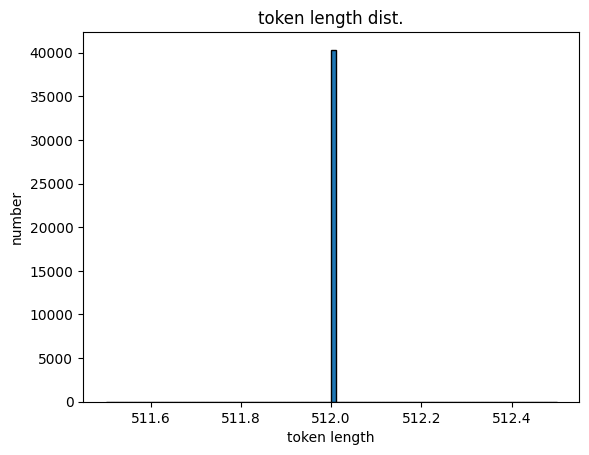

렉사일 지수 분포
count    40349.000000
mean       910.974151
std        287.370599
min         30.000000
25%        690.000000
50%        980.000000
75%       1120.000000
max       2650.000000
Name: lexile, dtype: float64


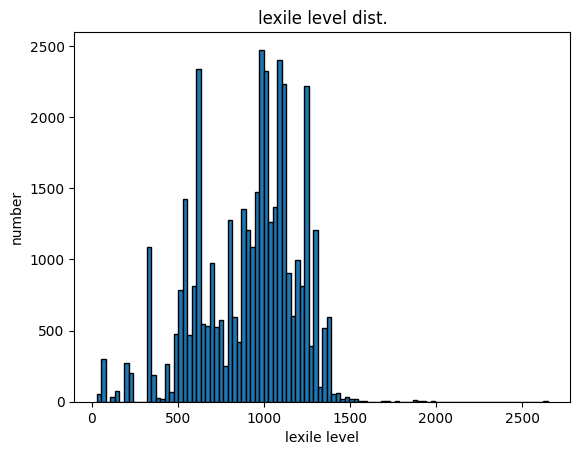

In [ ]:
# 렉사일 지수 분포 파악

# 토큰 길이 계산
final_data['token_length'] = final_data['input_ids'].apply(len)

# 통계 요약
print('토큰 길이 분포')
print(final_data['token_length'].describe())
# 히스토그램으로 분포 확인
import matplotlib.pyplot as plt
plt.hist(final_data['token_length'], bins=100, edgecolor='k')
plt.xlabel('token length')
plt.ylabel('number')
plt.title('token length dist.')
plt.show()

# 통계 요약
print('렉사일 지수 분포')
print(final_data['lexile'].describe())

# 히스토그램으로 분포 확인
plt.hist(final_data['lexile'], bins=100, edgecolor='k')
plt.xlabel('lexile level')
plt.ylabel('number')
plt.title('lexile level dist.')
plt.show()

In [ ]:
import numpy as np
quantiles = np.linspace(0, 1, 6+1)
print(final_data['lexile'].quantile(quantiles))


0.000000      30.0
0.166667     610.0
0.333333     810.0
0.500000     980.0
0.666667    1070.0
0.833333    1200.0
1.000000    2650.0
Name: lexile, dtype: float64


In [ ]:
#렉사일 점수를 6개의 범주로 나누기
bins = [0, 610, 810, 980, 1070, 1200, 2650]
labels = list(range(6))

lexile_categories = pd.cut(final_data['lexile'], labels=labels, bins=bins)

#각 범주 별 할당된 데이터
print(lexile_categories.value_counts())

#범주형 데이터를 정수로 변환
lexile_categories = lexile_categories.astype(int).tolist()
final_data['lexile'] = lexile_categories

print(final_data.head())

lexile
0    7185
4    7137
2    6925
3    6637
1    6383
5    6082
Name: count, dtype: int64
                                           input_ids  raw_index  token_length  \
0  [101, 2248, 8040, 3286, 3324, 2224, 12266, 116...          0           512   
1  [101, 2113, 1998, 2059, 7318, 2769, 2067, 1010...          0           511   
2  [101, 1037, 4187, 2602, 24358, 1012, 1996, 240...          1           512   
3  [101, 1997, 2245, 1010, 1996, 2916, 1997, 3633...          1           512   
4  [101, 8742, 2389, 2034, 25493, 3462, 2408, 199...          1           512   

                                     attention_masks  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                      token_type_ids  lexile  
0  [0, 0, 0, 0, 0, 0

In [ ]:
# final_data 피클로 저장
with open('final_data.pkl', 'wb') as f2:
    pickle.dump(final_data, f2)

from google.colab import files
files.download('final_data.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 4. 데이터 전처리 3 - final_data.pkl을 BERT에 입력, 결과물 저장 (bert_embeddings.pkl로 저장)

우리가 지금 진행하고자 하는 방식은 BERT의 파라미터를 고정시키고,
FC layer만 학습하는 방식

BERT에 데이터를 통과시킨 후 결과 데이터를 가지고
FC layer를 학습시키는 데 집중할 것임

처음에 생각했던 방식은,
토큰화된 데이터를 BERT와 FC layer 모두 통과시키는 방법으로 학습했음

각 에포크마다 데이터를 BERT에 다시 통과시켜야 하기 때문에 효율이 떨어짐

1. 토큰화된 데이터를 BERT에 입력한다
2. BERT에서 출력된 결과물을 가지고 FC layer를 학습시킨다.
3. FC layer에만 집중할 수 있으므로,
    에포크 수를 늘리던가(BERT가 포함되면 에포크 수는 3~5정도까지밖에 안 됨) 여러가지 방법을 가지고
    정확도와 효율을 동시에 잡을 것
4. 코랩의 Lexile data preprocessing.ipynb에서 진행할 예정

In [ ]:
from transformers import BertModel, BertTokenizer
import pandas as pd # 데이터 프레임 다루기
import pickle # 피클 형식 데이터 불러오기
import random # 데이터 검증 시 랜덤으로 하나 선택하기 위함
import torch
from torch.utils.data import Dataset, DataLoader

KeyboardInterrupt: 

In [ ]:
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [ ]:
# 구글 드라이브에 있는 pre bert final_data 로드
# Google Drive 마운트 (데이터 파일 접근을 위해)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path = '/content/drive/MyDrive/Colab Notebooks/LEXILE/data/pre bert final_data.pkl'
print(f"Loading data from: {path}")
with open(path, 'rb') as f:
    final_data = pickle.load(f)
    print(final_data.head())


final_data 추가 검증

In [ ]:
# 토크나이저 불러오기. 이미 토큰화된 데이터이지만 추가 검증을 위해 사용할 것
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
random_number = random.randint(0, len(final_data))


# 데이터 상태에 대한 추가 검증
print(f'final_data의 head:\n {final_data.head()}')
print(f'\n\n final_data의 구조:{final_data.shape}')


sample_input_ids = final_data['input_ids'].iloc[random_number]
decoded_text = tokenizer.decode(sample_input_ids)
print(f'\n\n랜덤하게 선택된 글 디코딩 {decoded_text}')

sample_attention_mask = final_data['attention_masks'].iloc[random_number]
if len(sample_attention_mask) == len(sample_input_ids):
    print("\n\nAttention mask와 input_ids의 길이가 동일합니다. 따라서 데이터에 문제가 없습니다.")
else:
    print("\n\nAttention mask와 input_ids의 길이가 다릅니다. 따라서 데이터에 문제가 있습니다.")

sample_token_type_ids = final_data['token_type_ids'].iloc[random_number]
if len(sample_token_type_ids) == len(sample_input_ids):
    print("\n\ntoken_type_ids와 input_ids의 길이가 동일합니다. 따라서 데이터에 문제가 없습니다.")
else:
    print("\n\ntoken_type_ids와 input_ids의 길이가 다릅니다. 따라서 데이터에 문제가 있습니다.")




In [ ]:
# 혹시 모르니 sample_ids를 추가
sample_ids = list(range(len(final_data)))
final_data['sample_ids'] = sample_ids
print(final_data.head())

마음의 안정을 위한 공백

In [ ]:
# 모델 불러오기.
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

# 모델을 평가 모드로 전환 (반대로 학습 가능한 유동적인 상태로 만들면 안 된다는 것으로 생각하기)
model.eval()

# 모델 사양 확인
# print(model)

In [ ]:
# **2. 데이터셋 클래스 정의**
class FinalDataDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        return {
            "input_ids": torch.tensor(row["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(row["attention_masks"], dtype=torch.long),
            "token_type_ids": torch.tensor(row["token_type_ids"], dtype=torch.long),
            "label": torch.tensor(row["lexile"], dtype=torch.long)
        }


In [ ]:
# **3. 데이터로더 생성**
BATCH_SIZE = 16
dataset = FinalDataDataset(final_data)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# **4. 모델 로드**
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # 평가 모드로 설정

device = torch.device("cuda")  # GPU 사용
model.to(device)

# **5. 결과 데이터프레임 저장**
results = []
for batch in dataloader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    token_type_ids = batch["token_type_ids"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    # Hidden states (마지막 레이어의 출력)
    last_hidden_state = outputs.last_hidden_state

    # [CLS] 토큰에 가중치를 두어 가중 평균 계산
    cls_token = last_hidden_state[:, 0, :]  # [CLS] 토큰의 임베딩
    all_tokens_mean = last_hidden_state.mean(dim=1)  # 전체 토큰의 평균

    # 가중 평균 계산 (가중치: 0.7 for CLS, 0.3 for mean)
    sentence_embeddings = 0.7 * cls_token + 0.3 * all_tokens_mean

    for i, embedding in enumerate(sentence_embeddings):
        results.append({
            "input_ids": batch["input_ids"][i].tolist(),
            "embedding": embedding.cpu().numpy().tolist(),
            "label": batch["label"][i].item()
        })

result_df = pd.DataFrame(results)



In [ ]:
print(result_df.head())
print(result_df.shape)

In [ ]:
# **5. 결과 DataFrame 저장**
# 결과 DataFrame 생성
#result_df = pd.DataFrame(results)

# 결과를 pickle 형식으로 저장
# result_df.to_pickle('/content/bert_embeddings.pkl')
# print("임베딩 벡터가 성공적으로 저장되었습니다!")


# 로컬 파일로 저장

with open('bert_embeddings.pkl', 'wb') as f3:
    pickle.dump(result_df, f3)


from google.colab import files
files.download('/content/bert_embeddings.pkl')
print("임베딩 벡터가 성공적으로 저장되었습니다!")


## 5. 데이터 전처리 4 - train_test_split, 데이터 텐서로 변환
+6. 모델 구축
+7. 모델 훈련 및 최선의 모델 저장
+8. 모델 평가




7. 모델 훈련 및 최선의 모델 저장
8. 모델 평가

사용한 방법론들

1. 데이터 정규화 - BERT에서 출력된 결과물을 FC layer에 입력하기 전에 먼저 정규화를 시킴
                정규화는 (편차/표준편차)로 계산
                표준편차가 0이 되거나, 너무 심하게 compression되는 것을 막기 위해 분모에 미세한 수 (1e-8) 더함

2. train_test_split

3. FC layer에 입력하기 위해 데이터 탠서화

4. TensorDataset으로 데이터 묶기 + DataLoader(batch_size = 16)로 TensorDataset을 불러오기

5. 모델 설계
    입력 레이어 - 768차원

    첫 번째 FC Layer - 768차원 to 512차원
    활성화 함수 1 (Relu)
    드롭아웃 1 Dropout(p=0.1)

    두 번째 FC Layer - 512차원 to 256차원
    활성화 함수 2 (Relu)
    드롭아웃 2 Dropout(p=0.1)

    세 번째 FC Layer - 256차원 to 128차원
    활성화 함수 3 (Relu)
    드롭아웃 3 Dropout(p=0.1)

    네 번째 FC Layer - 128차원 to 6차원 (실제로 분류할 범주의 개수)
    LayerNorm 추가
        네 번째 FC Layer의 결과물인 Logits 값의 최댓값과 최솟값의 차이가 20을 넘어가면
        softmax 함수 통과할 때 비정상적인 값 출력
        따라서 비정상적으로 큰 loss 값을 가지게 됨
        최댓값과 최솟값의 차이를 줄이기 위해 마지막에 LayerNorm 추가하는 것

    맨 끝에 softmax를 추가해야 하는 것 아닌가요?
        crossEntropy loss는 이렇게만 놔둬도 내재된 softmax 활용하여 알아서 loss 값 계산
        나중에 실제로 사용할 때에는 softmax를 뒤에 덧붙여야 함

6. 모델 훈련
    learning rate = 0.0001
    epochs = 150
    early stopping 적용 (patience = 10)
    loss function = crossEntropy
    sceduler 활용하여 learning rate를 loss에 따라 자동적으로 적절히 적용
    Xavier initialization 적용하여 initialization도 최대한 잘 되게 적용
    중요 !!!! loss 계산이 평균으로 되어 있는지 확인해야 함 !!!! loss를 단순합으로 계산하고 있었음
        그러니 loss가 엄청 크게 나오지...
        

7. 모델 평가 및 저장
    accuracy = correct / total로 계산

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pickle
import os

In [ ]:
# Google Drive 마운트 (데이터 파일 접근을 위해)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path = '/content/drive/MyDrive/Colab Notebooks/LEXILE/data/bert_embeddings.pkl'
print(f"Loading data from: {path}")
with open(path, 'rb') as f:
    postdata = pickle.load(f)
    print(postdata.head())

In [ ]:
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

혹시 모르니, 결측치 존재 여부 확인

In [ ]:
# NaN 제거 및 차원 확인
postdata = postdata.dropna(subset=['embedding', 'label'])
print(f"Data after NaN removal: {len(postdata)} rows.")
assert all(len(x) == 768 for x in postdata['embedding']), "임베딩 벡터 차원이 768이 아닙니다."
assert all(isinstance(x, int) and 0 <= x <= 5 for x in postdata['label']), "Labels are not valid integer class indices."

In [ ]:
print(postdata.head(), postdata.shape)
# NaN 값 확인
nan_count = postdata['embedding'].isnull().sum()
print(f"NaN 개수: {nan_count}")

nan_count = postdata['label'].isnull().sum()
print(f"NaN 개수: {nan_count}")

# NaN 값이 포함된 행 출력
print(postdata[postdata['embedding'].isnull()])
print(postdata[postdata['label'].isnull()])

# NaN이 포함된 행 제거
postdata = postdata.dropna(subset=['embedding'])
postdata = postdata.dropna(subset=['label'])

# 결과 확인
print(f"NaN 제거 후 데이터 개수: {postdata.shape}")

Data split

In [ ]:
# 데이터를 리스트로 변환
input_data = postdata['embedding'].tolist()
labels = postdata['label'].tolist()
print("Data converted to lists.")

# 데이터 정규화 (Scaling)
def normalize_embeddings(embeddings):
    embeddings = torch.tensor(embeddings, dtype=torch.float32)
    return (embeddings - embeddings.mean(dim=0)) / (embeddings.std(dim=0) + 1e-8)

input_data = normalize_embeddings(input_data)
print("Input data normalized.")

# Train-Test Split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    input_data, labels, test_size=0.2, random_state=42
)
print("Train-test split completed.")

# 리스트 내부 요소를 텐서로 변환
train_inputs = [torch.tensor(x, dtype=torch.float32) for x in train_inputs]
test_inputs = [torch.tensor(x, dtype=torch.float32) for x in test_inputs]

# 2D 텐서 생성
train_inputs = torch.stack(train_inputs)
test_inputs = torch.stack(test_inputs)

# 레이블 텐서로 변환
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)
print("Data converted to tensors.")

# TensorDataset 및 DataLoader 생성
train_dataset = TensorDataset(train_inputs, train_labels)
test_dataset = TensorDataset(test_inputs, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
print("DataLoaders created.")

# 클래스 가중치 계산
class_counts = torch.bincount(train_labels)
class_weights = 1.0 / class_counts.float()
class_weights /= class_weights.sum()
print(f"Class weights: {class_weights}")

Data converted to lists.
Input data normalized.
Train-test split completed.


<ipython-input-16-da796f6f6321>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = [torch.tensor(x, dtype=torch.float32) for x in train_inputs]
<ipython-input-16-da796f6f6321>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = [torch.tensor(x, dtype=torch.float32) for x in test_inputs]


Data converted to tensors.
DataLoaders created.
Class weights: tensor([0.1561, 0.1754, 0.1623, 0.1665, 0.1565, 0.1830])


In [ ]:
# 2. 모델 설계
class LexilePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, num_classes):
        super(LexilePredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)  # 첫 번째 FC Layer
        self.relu1 = nn.ReLU()                       # 활성화 함수 1
        self.dropout1 = nn.Dropout(p=0.1)            # 드롭아웃 1
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2) # 두 번째 FC Layer
        self.relu2 = nn.ReLU()                       # 활성화 함수 2
        self.dropout2 = nn.Dropout(p=0.1)            # 드롭아웃 2
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3) # 세 번째 FC Layer
        self.relu3 = nn.ReLU()                       # 활성화 함수 3
        self.dropout3 = nn.Dropout(p=0.1)            # 드롭아웃 3
        self.fc4 = nn.Linear(hidden_dim3, num_classes) # 네 번째 FC Layer
        self.layer_norm = nn.LayerNorm(num_classes)   # LayerNorm 추가

        # 가중치 초기화
        self._initialize_weights()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        x = self.layer_norm(x)  # Logits 정규화
        return x

    def _initialize_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)
        if self.fc1.bias is not None:
            nn.init.zeros_(self.fc1.bias)
        if self.fc2.bias is not None:
            nn.init.zeros_(self.fc2.bias)
        if self.fc3.bias is not None:
            nn.init.zeros_(self.fc3.bias)
        if self.fc4.bias is not None:
            nn.init.zeros_(self.fc4.bias)

# 하이퍼파라미터 설정
input_dim = 768
hidden_dim1 = 512
hidden_dim2 = 256
hidden_dim3 = 128
num_classes = 6
learning_rate = 0.0001
epochs = 150
patience = 10  # Early Stopping patience

# 모델 저장 경로 설정
model_dir = '/content/drive/MyDrive/Colab Notebooks/LEXILE/models'
os.makedirs(model_dir, exist_ok=True)

best_model_path = os.path.join(model_dir, 'lexile_fc_model_best.pth')
final_model_path = os.path.join(model_dir, 'final_lexile_fc_model.pth')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 모델 초기화
model = LexilePredictor(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, num_classes).to(device)
print("Model initialized with additional FC layer, LayerNorm, and Xavier initialization.")

# 손실 함수 및 옵티마이저
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)
print("Loss function, optimizer, and scheduler set.")

# Early Stopping 초기화
best_loss = float('inf')
patience_counter = 0

Using device: cpu
Model initialized with additional FC layer, LayerNorm, and Xavier initialization.
Loss function, optimizer, and scheduler set.


In [ ]:
# 3. 모델 훈련
for epoch in range(epochs):
    model.train()
    batch_losses = []  # Track batch losses
    correct = 0
    total = 0

    for batch in train_loader:
        inputs = batch[0].to(device)
        labels = batch[1].to(device)

        # 순전파
        outputs = model(inputs)
        #print(f"Logits range: min={outputs.min().item()}, max={outputs.max().item()}")
        #logits_diff = outputs.max().item() - outputs.min().item()
        #print(f"Logits difference: {logits_diff}")
        #if logits_diff > 20:
        #    print("Logits difference exceeds threshold; potential instability.")
        loss = criterion(outputs, labels)

        # 역전파 및 가중치 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 손실 및 정확도 계산
        batch_losses.append(loss.item())
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = sum(batch_losses) / len(batch_losses)  # Average loss for the epoch
    accuracy = correct / total
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Scheduler 스텝
    scheduler.step(epoch_loss)

    # Early Stopping 조건 확인
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
        # 모델 저장 (최고 성능 기준)
        torch.save(model.state_dict(), best_model_path)
        print("Best model saved.")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break


Epoch 1/150, Loss: 0.1611, Accuracy: 0.9417
Best model saved.
Epoch 2/150, Loss: 0.1596, Accuracy: 0.9429
Best model saved.
Epoch 3/150, Loss: 0.1584, Accuracy: 0.9427
Best model saved.
Epoch 4/150, Loss: 0.1601, Accuracy: 0.9419
Epoch 5/150, Loss: 0.1552, Accuracy: 0.9440
Best model saved.
Epoch 6/150, Loss: 0.1532, Accuracy: 0.9444
Best model saved.
Epoch 7/150, Loss: 0.1546, Accuracy: 0.9433
Epoch 8/150, Loss: 0.1538, Accuracy: 0.9448
Epoch 9/150, Loss: 0.1507, Accuracy: 0.9445
Best model saved.
Epoch 10/150, Loss: 0.1517, Accuracy: 0.9443
Epoch 11/150, Loss: 0.1455, Accuracy: 0.9467
Best model saved.
Epoch 12/150, Loss: 0.1471, Accuracy: 0.9448
Epoch 13/150, Loss: 0.1457, Accuracy: 0.9456
Epoch 14/150, Loss: 0.1436, Accuracy: 0.9479
Best model saved.
Epoch 15/150, Loss: 0.1442, Accuracy: 0.9468
Epoch 16/150, Loss: 0.1420, Accuracy: 0.9468
Best model saved.
Epoch 17/150, Loss: 0.1416, Accuracy: 0.9474
Best model saved.
Epoch 18/150, Loss: 0.1438, Accuracy: 0.9459
Epoch 19/150, Loss:

In [ ]:
# 4. 모델 평가
model.eval()
correct = 0
total = 0
val_loss = 0

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        labels = batch[1].to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
val_loss /= len(test_loader)
print(f"Test Accuracy: {accuracy:.4f}, Validation Loss: {val_loss:.4f}")


Test Accuracy: 0.8263, Validation Loss: 0.9202
